# Bone Fracture Detection - MURA

Here we attempt to create an algorithm to classify images for bone fracture, for this an input image is given and output is given as a “Positive” or “Negative” label. The input data is in the form of X Ray images of the bones. Hence, an appropriate supervised learning model is to be trained with the data to give correct label to the input image to predict a fracture. Some preprocessing of the data (converting RGB images to Grayscale) is also necessary here. This repository contains a Keras implementation of a 169 layer Densenet Model on MURA dataset

## Loading Dataset

In [22]:
import os
import numpy as np
import cv2
import random
import keras.backend as K

In [23]:
def load_path(root_path = './valid/XR_ELBOW', size = 512): #given path is a placeholder data only
	'''
	load MURA dataset

	'''

	Path = []
	labels = []
	for root,dirs,files in os.walk(root_path): #Read all pictures, os.walk Return to iterator genertor Traverse all files
		for name in files:
			path_1 = os.path.join(root,name)
			Path.append(path_1)
			if root.split('_')[-1]=='positive':	 #positive Label is 1，otherwise 0；
				labels+=[1]   	          	 #Last level directory file patient11880\\study1_negative\\image3.png
			else:
			    labels+=[0]
	print (len(Path))
	labels = np.asarray(labels)
	return Path, labels

In [24]:
def load_image(Path = './valid/XR_ELBOW', size = 512): #given path is a placeholder data only
	Images = []
	for path in Path:
		try:
			image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
			image = cv2.resize(image,(size,size))
			image = randome_rotation_flip(image,size)
			Images.append(image)

		except Exception as e:
			print(str(e))

	Images = np.asarray(Images).astype('float32')

	mean = np.mean(Images)			#normalization
	std = np.std(Images)
	Images = (Images - mean) / std
	
	if K.image_data_format() == "channels_first":
		Images = np.expand_dims(Images,axis=1)		   #Extended dimension 1
	if K.image_data_format() == "channels_last":
		Images = np.expand_dims(Images,axis=3)             #Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1) 
	return Images

In [25]:
def randome_rotation_flip(image,size = 512):
	if random.randint(0,1):
		iamge = cv2.flip(image,1) # 1-->horizontal flip 0-->Vertical flip -1-->Horizontal and vertical

	if random.randint(0,1):
		angle = random.randint(-30,30)
		M = cv2.getRotationMatrix2D((size/2,size/2),angle,1)
		#The third parameter: the size of the transformed image
		image = cv2.warpAffine(image,M,(size,size))
	return image

## Training The Model

In [26]:
from __future__ import print_function

import os
import time
import datetime
import random
import json
import argparse
import densenet
import numpy as np
import keras.backend as K

from keras.optimizers import Adam
from keras.utils import np_utils

import data_loader

In [27]:
def run_MURA(batch_size, nb_epoch, depth, nb_dense_block, nb_filter, growth_rate, dropout_rate, learning_rate, weight_decay, plot_architecture):
    """
    Run MURA experiments

    :parameter batch_size: int -- batch size
    :parameter nb_epoch: int -- number of training epochs
    :parameter depth: int -- network depth
    :parameter nb_dense_block: int -- number of dense blocks
    :parameter nb_filter: int -- initial number of conv filter
    :parameter growth_rate: int -- number of new filters added by conv layers
    :parameter dropout_rate: float -- dropout rate
    :parameter learning_rate: float -- learning rate
    :parameter weight_decay: float -- weight decay
    :parameter plot_architecture: bool -- whether to plot network architecture

    """

    ###################
    # Data processing #
    ###################

    
    im_size = 320   #Test modification parameters size root_path nb_epoch nb_dense_block         
    X_train_path, Y_train = data_loader.load_path(root_path = './train/XR_HUMERUS',size = im_size)  
    X_valid_path, Y_valid = data_loader.load_path(root_path = './valid/XR_HUMERUS', size = im_size)  

    X_valid = data_loader.load_image(X_valid_path,im_size)  #Load verification set ahead of time
    Y_valid = np.asarray(Y_valid)
    nb_classes = 1                                
    img_dim = (im_size,im_size,1)                 #Plus the last dimension, type is tuple

    
    ###################
    # Construct model #
    ###################

    model = densenet.DenseNet(nb_classes, img_dim, depth, nb_dense_block, growth_rate, nb_filter, dropout_rate=dropout_rate, weight_decay=weight_decay)
    # Model output
    model.summary()

    # Build optimizer
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

    if plot_architecture:
        from keras.utils import plot_model
        plot_model(model, to_file='./figures/densenet_archi.png', show_shapes=True)

    ####################
    # Network training #
    ####################

    print("Start Training")

    list_train_loss = []
    list_valid_loss = []
    list_learning_rate = []
    best_record = [100,0,100,100] #Recording optimal [verification set loss function value, accuracy rate, training set data set loss difference,acc difference]
    start_time = datetime.datetime.now()
    for e in range(nb_epoch):

        if e == int(0.25 * nb_epoch):
            K.set_value(model.optimizer.lr, np.float32(learning_rate / 10.))

        if e == int(0.5 * nb_epoch):
            K.set_value(model.optimizer.lr, np.float32(learning_rate / 50.))

        if e == int(0.75 * nb_epoch):
            K.set_value(model.optimizer.lr, np.float32(learning_rate / 100.))


        split_size = batch_size
        num_splits = len(X_train_path) / split_size

        arr_all = np.arange(len(X_train_path)).astype(int)
        random.shuffle(arr_all)                 #Randomly disrupted index order
        arr_splits = np.array_split(arr_all, num_splits)

        l_train_loss = []
        batch_train_loss = []
        start = datetime.datetime.now()

        for i,batch_idx in enumerate(arr_splits):


            X_batch_path,Y_batch = [],[]
            for idx in batch_idx:
                X_batch_path.append(X_train_path[idx])
                Y_batch.append(Y_train[idx])
            X_batch = data_loader.load_image(Path = X_batch_path, size =im_size)
            Y_batch = np.asarray(Y_batch)
            train_logloss, train_acc = model.train_on_batch(X_batch, Y_batch)

            l_train_loss.append([train_logloss, train_acc])
            batch_train_loss.append([train_logloss, train_acc])
            if i %100 == 0:
                loss_1, acc_1 = np.mean(np.array(l_train_loss), 0)
                loss_2, acc_2 = np.mean(np.array(batch_train_loss), 0)
                batch_train_loss = []           #Current 100 batch loss function and accuracy
                print ('[Epoch {}/{}] [Batch {}/{}] [Time: {}] [all_batchs--> train_epoch_logloss: {:.5f}, train_epoch_acc:{:.5f}] '.format(e+1,nb_epoch,i, len(arr_splits),datetime.datetime.now() - start,loss_1,acc_1), '[this_100_batchs-->train_batchs_logloss: {:.5f}, train_batchs_acc:{:.5f}]'.format(loss_2, acc_2))

        # Run verification set
        valid_logloss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=0, batch_size=64)
        list_train_loss.append(np.mean(np.array(l_train_loss), 0).tolist())
        list_valid_loss.append([valid_logloss, valid_acc])
        list_learning_rate.append(float(K.get_value(model.optimizer.lr)))
        # to convert numpy array to json serializable
        print('[Epoch %s/%s] [Time: %s, Total_time: %s]' % (e + 1, nb_epoch, datetime.datetime.now() - start, datetime.datetime.now() - start_time),end = '')
        print('[train_loss_and_acc:{:.5f} {:.5f}] [valid_loss_acc:{:.5f} {:.5f}]'.format(list_train_loss[-1][0], list_train_loss[-1][1],list_valid_loss[-1][0],list_valid_loss[-1][1]))


        d_log = {}
        d_log["batch_size"] = batch_size
        d_log["nb_epoch"] = nb_epoch
        d_log["optimizer"] = opt.get_config()
        d_log["train_loss"] = list_train_loss
        d_log["valid_loss"] = list_valid_loss
        d_log["learning_rate"] = list_learning_rate

        json_file = os.path.join('./log/experiment_log_MURA.json')
        with open(json_file, 'w') as fp:
            json.dump(d_log, fp, indent=4, sort_keys=True)



        record = [valid_logloss,valid_acc,abs(valid_logloss-list_train_loss[-1][0]),abs(valid_acc-list_train_loss[-1][1]),]
        if ((record[0]<=best_record[0]) &(record[1]>=best_record[1])) :
            if e <= int(0.25 * nb_epoch)|(record[2]<=best_record[2])&(record[3]<=best_record[3]):#Add a difference judgment after a quarter epoch
                best_record=record                      #Record the smallest [validation set loss function value, accuracy rate, training set data loss difference, acc difference]
                print('saving the best model:epoch',e+1,best_record)
                model.save('save_models/best_MURA_modle@epochs{}.h5'.format(e+1))
        model.save('save_models/MURA_modle@epochs{}.h5'.format(e+1))

In [31]:
if __name__ == '__main__':
    # Use default parameters directly
    parser = argparse.ArgumentParser(description='Run MURA experiment')
    parser.add_argument('--batch_size', default=8, type=int, #default=64, earlier it was 8
                        help='Batch size')
    parser.add_argument('--nb_epoch',  type=int, default=52,#default=30, earlier it was 32
                        help='Number of epochs')
    parser.add_argument('--depth', type=int, default=6*3+4,#default=7,    #This parameter is no longer used, set directly from the list in the densenet 6*3+4
                        help='Network depth')
    parser.add_argument('--nb_dense_block', type=int, default=4, #default=1,
                        help='Number of dense blocks')
    parser.add_argument('--nb_filter', type=int, default=16, #earlier it was 16
                        help='Initial number of conv filters')
    parser.add_argument('--growth_rate', type=int, default=12, #earlier it was 12
                        help='Number of new filters added by conv layers')
    parser.add_argument('--dropout_rate', type=float, default=0.2,
                        help='Dropout rate')
    parser.add_argument('--learning_rate', type=float, default=1E-3, #default=1E-3,
                        help='Learning rate')
    parser.add_argument('--weight_decay', type=float, default=1E-4,
                        help='L2 regularization on weights')
    parser.add_argument('--plot_architecture', type=bool, default=False,#default=False,
                        help='Save a plot of the network architecture')

    args = parser.parse_args()

    print("Network configuration:")
    for name, value in parser.parse_args()._get_kwargs():
        print(name, value)

    list_dir = ["./log", "./figures", "./save_models"]
    for d in list_dir:
        if not os.path.exists(d):
            os.makedirs(d)

    run_MURA(args.batch_size, args.nb_epoch, args.depth, args.nb_dense_block,  args.nb_filter, args.growth_rate, args.dropout_rate, args.learning_rate, args.weight_decay, args.plot_architecture)

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--nb_epoch NB_EPOCH] [--depth DEPTH]
                             [--nb_dense_block NB_DENSE_BLOCK]
                             [--nb_filter NB_FILTER]
                             [--growth_rate GROWTH_RATE]
                             [--dropout_rate DROPOUT_RATE]
                             [--learning_rate LEARNING_RATE]
                             [--weight_decay WEIGHT_DECAY]
                             [--plot_architecture PLOT_ARCHITECTURE]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/ibrahimirfan/Library/Jupyter/runtime/kernel-40988462-c9da-4119-848f-e637a63d3da3.json


SystemExit: 2

## Loading The Model

In [32]:

import os
import time
import datetime
import random
import json
import argparse
import densenet
import numpy as np
import keras.backend as K

from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import load_model
import data_loader
from keras.models import model_from_json

In [33]:
im_size = 320



model = densenet.DenseNet(nb_classes=1, img_dim=(320,320,1), depth=22, nb_dense_block=4, growth_rate=12, nb_filter=16, dropout_rate=0.2, weight_decay=1E-4)

model.load_weights('./save_models/MURA_modle@epochs52.h5')

X_valid_path, Y_valid = data_loader.load_path(root_path = './valid/XR_HUMERUS', size = im_size)
X_valid = data_loader.load_image(X_valid_path,im_size)
y1 = model.predict(X_valid, batch_size=None, verbose=0, steps=None)

j = len(y1)

for i in range (0, j):
	if y1[i]>0.5 :
		print(X_valid_path[i],":\t","Positive\t", y1[i])
	else:
		print(X_valid_path[i],":\t","Negative\t", y1[i])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ibrahimirfan/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sn/mv6gpvjx2mvd4038bxgrt8700000gn/T/ipykernel_90373/1513157940.py", line 5, in <module>
    model = densenet.DenseNet(nb_classes=1, img_dim=(320,320,1), depth=22, nb_dense_block=4, growth_rate=12, nb_filter=16, dropout_rate=0.2, weight_decay=1E-4)
  File "/Users/ibrahimirfan/Downloads/Bone-Fracture-Detection---MURA-master/densenet.py", line 131, in DenseNet
    if K.image_dim_ordering() == "th":
AttributeError: module 'keras.backend' has no attribute 'image_dim_ordering'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ibrahimirfan/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  F

## Training Accuracy

In [34]:
import matplotlib.pylab as plt
import json
import numpy as np

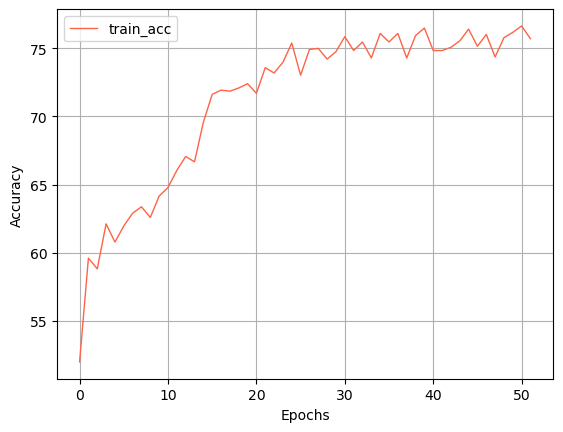

In [35]:
def plot_MURA(save=True):

    with open("./log/experiment_log_MURA.json", "r") as f:
        d = json.load(f)

    train_accuracy = 100 * (np.array(d["train_loss"])[:, 1])

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epochs')                                                   
    ax1.plot(train_accuracy, color="tomato", linewidth=1, label='train_acc')
    
    ax1.legend(loc=0)
    

	
    ax1.grid(True)

    if save:
        fig.savefig('./figures/plot_MURA_train_acc.jpg')

    plt.show()
    plt.clf()
    plt.close()

if __name__ == '__main__':
    plot_MURA()

## Validation Accuracy

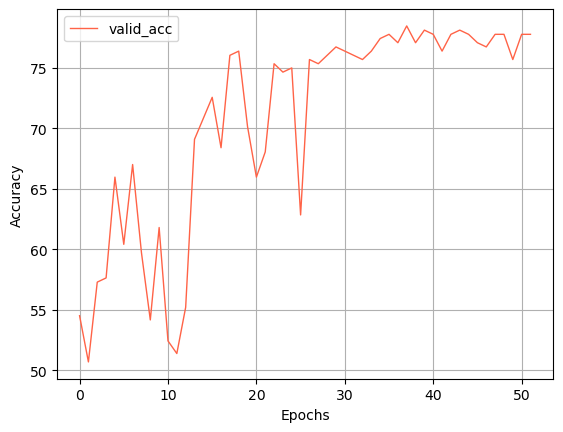

In [36]:
def plot_MURA(save=True):

    with open("./log/experiment_log_MURA.json", "r") as f:
        d = json.load(f)


    valid_accuracy = 100 * (np.array(d["valid_loss"])[:, 1])

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epochs')                                                   
    ax1.plot(valid_accuracy, color="tomato", linewidth=1, label='valid_acc')
    
    ax1.legend(loc=0)
    

	
    ax1.grid(True)

    if save:
        fig.savefig('./figures/plot_MURA_valid_acc.jpg')

    plt.show()
    plt.clf()
    plt.close()

if __name__ == '__main__':
    plot_MURA()

# Training Loss

In [37]:
import matplotlib.pylab as plt
import json
import numpy as np

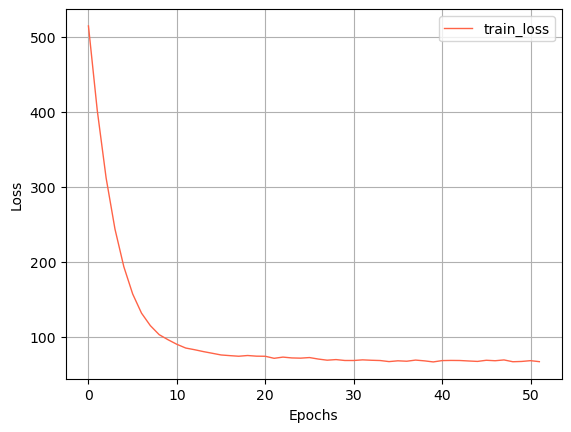

In [38]:
def plot_MURA(save=True):

    with open("./log/experiment_log_MURA.json", "r") as f:
        d = json.load(f)


    train_loss = 100 * np.array(d["train_loss"])[:, 0]

    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')                                                   
    ax1.plot(train_loss, color="tomato", linewidth=1, label='train_loss')
    
    ax1.legend(loc=0)
    

	
    ax1.grid(True)

    if save:
        fig.savefig('./figures/plot_MURA_train_loss.jpg')

    plt.show()
    plt.clf()
    plt.close()

if __name__ == '__main__':
    plot_MURA()

# Validation Loss

In [39]:
import matplotlib.pylab as plt
import json
import numpy as np

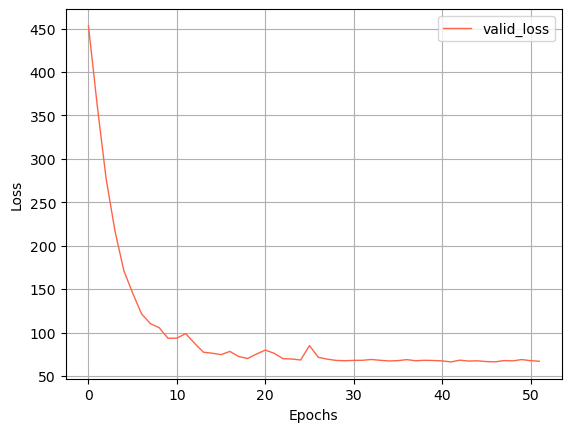

In [40]:
def plot_MURA(save=True):

    with open("./log/experiment_log_MURA.json", "r") as f:
        d = json.load(f)


    valid_loss = 100 * np.array(d["valid_loss"])[:, 0]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')                                                   
    ax1.plot(valid_loss, color="tomato", linewidth=1, label='valid_loss')
    
    ax1.legend(loc=0)
    

	
    ax1.grid(True)

    if save:
        fig.savefig('./figures/plot_MURA_valid_loss.jpg')

    plt.show()
    plt.clf()
    plt.close()

if __name__ == '__main__':
    plot_MURA()
